## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
# from numpy.linalg import inv as inv

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import decoder functions
import Decoder_funcs
from Decoder_funcs import get_vaf

from decoders import WienerCascadeDecoder
from decoders import WienerFilterDecoder
from decoders import DenseNNDecoder
from decoders import SimpleRNNDecoder

Using Theano backend.


In [2]:
x=np.random.rand(1000,5)
y=np.zeros([1000,2])
y[:,0]=(x[:,0]+x[:,1])**2
y[:,1]=(x[:,2]+x[:,3])**4
# model_wf=Model(model_type='WienerCascade')
# model_wf.fit(x,y)
# y_pred_wf=model_wf.predict(x)

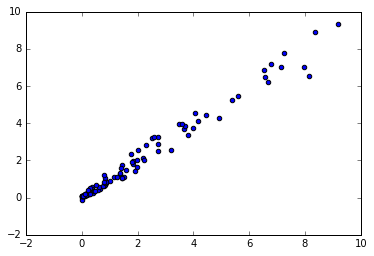

In [3]:
model_wc=WienerCascade(degree=4)
model_wc.fit(x,y)
y_pred_wc=model_wc.predict(x)
plt.scatter(y[:,1],y_pred_wc[:,1])

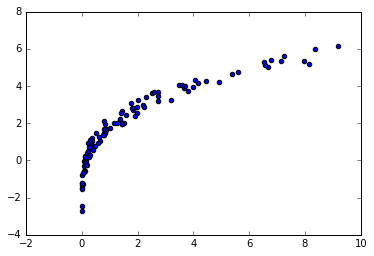

In [4]:
model_wf=WienerFilter()
model_wf.fit(x,y)
y_pred_wf=model_wf.predict(x)
plt.scatter(y[:,1],y_pred_wf[:,1])

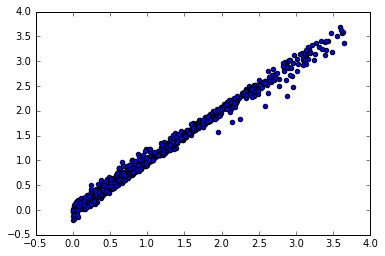

In [11]:
model_dnn=DenseNNDecoder(units=[10,10,10],num_epochs=100,verbose=0)
model_dnn.fit(x,y)
y_pred_dnn=model_dnn.predict(x)
plt.scatter(y[:,0],y_pred_dnn[:,0])

In [ ]:
model_wc=WienerCascade()
model_wf=WienerFilter()

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model=LinearRegression()

In [ ]:
model.fit()

## Import Data

**Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin**

**The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"**

In [5]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
folder='/Users/jig289/Dropbox/Grad_School/Research/Projects/In_Progress/Decoding/DataFiles/'
# folder='/home/jglaser2/Data/DecData/'

with open(folder+'m1_test_data_p3.pickle','rb') as f:
    neural_data,vels_binned,pos_binned,acc_binned=pickle.load(f)
    


## Define Covariates ##

### User Options: Define what time period to use spikes from

In [6]:
#This is relevant for all decoders except the Kalman filter (KF)

bins_current=1 #Whether to use concurrent time bin of neural data
bins_before=13 #How many bins of neural data prior to the output are used for decoding
bins_after=0 #How many bins of neural data after (and including) the output are used for decoding
bins_surrounding=bins_before+bins_before+bins_after


# Below is only relevant for the KF

lag=-2 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### Get Input Covariates

In [7]:
#Function to get the covariate matrix that includes spike history from previous bins
#This puts the spikes in the format for the RNN
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#Put in "flat" format for XGB and linear decoders
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Format for Kalman filter
X_kf=neural_data

### Get Output Covariates

In [8]:
#Set decoding output for all decoders except the KF
y=vels_binned


#Set decoding output for the KF
# pos=np.zeros(vels_binned.shape)
# pos[0,:]=0
# for i in range(pos.shape[0]-1):
#     pos[i+1,0]=pos[i,0]+vels_binned[i,0]*.05
#     pos[i+1,1]=pos[i,1]+vels_binned[i,1]*.05
    
# temp=np.diff(vels_binned,axis=0)
# acc=np.concatenate((temp,temp[-1:,:]),axis=0)

# y_kf=np.concatenate((pos,vels_binned,acc),axis=1)

y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

### Process Covariates

In [9]:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [10]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)
X_kf=zscore_nan(X_kf,axis=0)

#Zero-center outputs
y_mean=np.mean(y,axis=0)
y=y-y_mean

y_kf_mean=np.mean(y_kf,axis=0)
y_kf=y_kf-y_kf_mean

In [11]:
#More Kalman filter preprocessing
num_examples=X.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

## Split into training/testing/validation sets

### User Options

In [12]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

### Split Data: For all decoders except KF

In [13]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

### Split Data: For KF

In [14]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

## Run Decoders

### Wiener Filter (Linear Regression)

In [12]:
#Fit model
model_wf=WienerFilter()
model_wf.fit(X_flat_train,y_train)
#Get predictions
y_valid_pred_lin=model_wf.predict(X_flat_valid)
#Get metric of fit
vafs_lin=get_vaf(y_valid,y_valid_pred_lin)
print('VAFS:', vafs_lin)

VAFS: [0.75176754708627835, 0.75100935332779462]


### Wiener Cascade (Linear Nonlinear Model)

In [22]:
#Fit model
model_wc=WienerCascade(degree=3)
model_wc.fit(X_flat_train,y_train)
#Get predictions
y_valid_pred_wc=model_wc.predict(X_flat_valid)
#Get metric of fit
vafs_wc=get_vaf(y_valid,y_valid_pred_wc)
print('VAFS:', vafs_wc)

VAFS: [0.75846086040360672, 0.76774970824995847]


### XGBoost (Extreme Gradient Boosting)

In [20]:
#Fit model
model_xgb=Decoder_funcs.xgb_model(X_flat_train,y_train,max_depth=4,num_round=300)
#Get predictions
y_valid_pred_xgb=Decoder_funcs.xgb_predict(model_xgb,X_flat_valid)
#Get metric of fit
vafs_xgb=get_vaf(y_valid,y_valid_pred_xgb)
print('VAFS:', vafs_xgb)

('VAFS:', [0.77313957228279406, 0.78690740858400454])


In [ ]:
2/200: 0.76251557876927645, 0.77286566815470881
3/200: 0.78257987600003387, 0.77279201623015137
4/200: 0.77205455297414716, 0.78635811720376303 **Faster than 300 and about the same values
    
3/300: 0.78630663593127192, 0.77747315080931134
4/300: 0.77313957228279406, 0.78690740858400454

### Dense Neural Network

In [25]:
#Fit model
model_dnn=DenseNN(num_layers=1,units=400,dropout=0.25,num_epochs=10)
model_dnn.fit(X_flat_train,y_train)
#Get predictions
y_valid_pred_dnn=model_dnn.predict(X_flat_valid)
#Get metric of fit
vafs_dnn=get_vaf(y_valid,y_valid_pred_dnn)
print('VAFS:', vafs_dnn)

VAFS: [0.80203454489812487, 0.75351857274642642]


In [35]:
a=[400,200]
a[0]

400

In [49]:
b=10
# isinstance( b, int )

In [46]:
b=[10,2]

In [52]:
b=np.array([10,2])

In [53]:
try:
    b[0]
except:
    b=[b]

In [55]:
b[1]

2

In [ ]:
400/0/5: 0.80192961027785592, 0.758705551445501
400/0/10: 0.7973016946195115, 0.76783414467641764

400/.25/5: 0.7979729833068373, 0.75206343225833661   
400/.25/10: 0.80309043752135612, 0.76763595451209776 ***
400/.25/20: 0.7986006696922151, 0.7661383019233946
    
200/0/5: 0.78381436036057694, 0.74198965685910312
200/0/10: 0.7850355991713015, 0.74928160648672237
    
600/.25/5: 0.79662408981260702, 0.76298187365639392
600/.25/10: 0.80626463514822566, 0.76255870542192739
    
    
    
400/.25/10: 0.80203454489812487, 0.75351857274642642

In [18]:
#Fit model
model_dnn2=Decoder_funcs.DNN_model2(X_flat_train,y_train,units=200,dropout=.25,num_epochs=10)
#Get predictions
y_valid_pred_dnn2=model_dnn2.predict(X_flat_valid)
#Get metric of fit
vafs_dnn2=get_vaf(y_valid,y_valid_pred_dnn2)
print('VAFS:', vafs_dnn2)

('VAFS:', [0.79486496489201452, 0.75346650333910725])


In [ ]:
400/0/10: 0.79658955256353414, 0.76830744475485702

400/.25/10: 0.80145781315005782, 0.73593936386377123
400/.25/20: 0.80179618456713331, 0.76693796956448224
    
400/.5/10: 0.78723219311433212, 0.74681341258516065
    
200/0/10: 0.79578721243972839, 0.75505749894743757
200/.25/10: 0.79486496489201452, 0.75346650333910725
200/.25/20: 0.80100388983566673, 0.75996376250503228

In [ ]:
1/2 as many units in 2nd layer

400/0/10: 0.79546878039667912, 0.75495771502513609
400/.25/10: 0.79782188229078688, 0.75932799250281102
400/.5/10: 0.78644433970157612, 0.73848438907816938    
    
200/.25/10: 0.77875181866332133, 0.75747468474358171

### Simple RNN

In [15]:
#Fit model
model_rnn=SimpleRNNDecoder(units=400,dropout=0,num_epochs=5)
model_rnn.fit(X_train,y_train)
#Get predictions
y_valid_pred_rnn=model_rnn.predict(X_valid)
#Get metric of fit
vafs_rnn=get_vaf(y_valid,y_valid_pred_rnn)
print('VAFS:', vafs_rnn)

VAFS: [0.81956377821395354, 0.79733931661422808]


In [ ]:
400/10: 0.8179415562127349, 0.78331080265241537
400/5: 0.8272756785254759, 0.78938009849888735 ****
400/.25/10: 0.81565341686753234, 0.76406889948571532
400/.25/5: 0.80626917220137151, 0.75311729792391746

### GRU (Gated Recurrent Unit)

In [21]:
#Fit model
model_gru=Decoder_funcs.GRU_model(X_train,y_train,units=400,dropout=0,num_epochs=5)
#Get predictions
y_valid_pred_gru=model_gru.predict(X_valid)
#Get metric of fit
vafs_gru=get_vaf(y_valid,y_valid_pred_gru)
print('VAFS:', vafs_gru)

('VAFS:', [0.86893023090964339, 0.83742338246052572])


In [ ]:
400/10: 0.87255717267620037, 0.83728626003289441
400/5: [0.86893023090964339, 0.83742338246052572]

### LSTM (Long Short Term Memory)

In [12]:
#Fit model
model_lstm=Decoder_funcs.LSTM_model(X_train,y_train,units=400,dropout=0,num_epochs=5)
#Get predictions
y_valid_pred_lstm=model_lstm.predict(X_valid)
#Get metric of fit
vafs_lstm=get_vaf(y_valid,y_valid_pred_lstm)
print('VAFS:', vafs_lstm)

('VAFS:', [0.86602019499246363, 0.82939673326963659])


In [ ]:
400/10: [0.88011000858631538, 0.84203013604606314]
400/5: [0.86602019499246363, 0.82939673326963659]

### Kalman Filter

In [30]:
#Fit model
model_kf=Decoder_funcs.kf_model(X_kf_train,y_kf_train)
#Get predictions
y_valid_pred_kf=Decoder_funcs.kf_predict(model_kf,X_kf_valid,y_kf_valid)
#Get metric of fit
vafs_kf=get_vaf(y_kf_valid,y_valid_pred_kf)
print('VAFS:',vafs_kf[2:4])

('VAFS:', [0.71262165722140391, 0.71809235391216308])


In [ ]:
0.72589104187753462, 0.72807415081228388

In [31]:
vafs_kf

[0.72975837456300086,
 0.64789131743295547,
 0.71262165722140391,
 0.71809235391216308,
 0.44111798205746644,
 0.27265038342812109]

## Make Plots

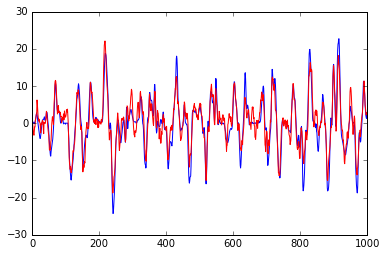

In [17]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_lin=plt.figure()
plt.plot(y_valid[1000:2000,0]+y_mean[0],'b')
plt.plot(y_valid_pred_lin[1000:2000,0]+y_mean[0],'r')
#Save figure
# fig_x_lin.savefig('x_velocity_decoding.eps')